## Challenge PriceLab

Considere el problema de maximización de revenue

1 de un supermercado. Usted cuenta con data
semanal de ventas del 01/01/2022 al 18/02/2024 en el archivo ventas.csv. En este archivo cuenta con
los siguientes campos:

1. Fecha. Fecha de venta del producto
2. Código. Código del producto a nivel de SKU
3. Descripción. Descripción del producto
4. Precio unitario. Precio unitario del producto
5. Costo unitario. Costo unitario del producto
6. Cantidad vendida. N ́umero de unidades vendidas del producto

In [ ]:
#!pip install prophet
#!pip install pandas
#!pip install seaborn
#!pip install matplotlib
#!pip install numpy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [3]:
sns.set_theme()

In [4]:
path_data = '../data/ventas.csv'

In [5]:
df = pd.read_csv(path_data, encoding='iso-8859-1')
df.columns = ['fecha', 'codigo', 'descripcion', 'precio_unitario', 
              'costo_unitario', 'cantidad_vendida']

In [6]:
print(f"Numero de SKU's únicos: {df['codigo'].nunique()}")

Numero de SKU's únicos: 12


Generación del diccionario de Codigos y Descripciones

In [7]:
dict_sku = df[['codigo','descripcion']].drop_duplicates().reset_index(drop=True).set_index('codigo').to_dict()['descripcion']

Verificando si un SKU puede ser vendido con dos precios distintos en una semana

In [8]:
dfp = df[df['codigo']==10096015].groupby(['fecha']).agg({'precio_unitario':'unique'})
dfp['len'] = dfp['precio_unitario'].apply(lambda x: len(x))
dfp.sort_values('len', ascending=False).head()

,precio_unitario,len
fecha,,
2022-26,"[15.9, 14.2, 12.5]",3
2023-33,"[16.2, 15.9, 6.0]",3
2023-32,"[16.2, 12.0, 15.9]",3
2023-31,"[6.0, 16.2, 8.0]",3
2023-29,"[16.2, 15.9, 14.25]",3


Se verifica que si pueden haber dos precios en 1 día. Por lo que el mejor y más rapido enfoque es hacer el calculo por registro de precios y costos totales y luego agrupar la información por semana para desarrollar una serie de tiempo por cada SKU.

In [9]:
df_general = df.copy()
df_general['precio_total'] = df_general['precio_unitario'] * df_general['cantidad_vendida']
df_general['costo_total']  = df_general['costo_unitario'] * df_general['cantidad_vendida']
df_general = df_general.groupby(['codigo','fecha']).agg({'cantidad_vendida':'sum',
                                                     'precio_total':'sum',
                                                     'costo_total':'sum'}).reset_index()

Ademas se verifica si se tienen cantidades de puntos similares por cada serie en cada SKU

In [10]:
df_general.groupby('codigo').count()

,fecha,cantidad_vendida,precio_total,costo_total
codigo,,,,
100570,112,112,112,112
100714,112,112,112,112
108930,112,112,112,112
109885,109,109,109,109
10000095,112,112,112,112
10022018,112,112,112,112
10035282,111,111,111,111
10059021,112,112,112,112
10083638,112,112,112,112


Ya que no se tienen similares cantidades de puntos, lo general es desarrollar un algoritmo por cada SKU. Ya que ese abordaje es bastante amplio en análisis usando tecnicas de suavizamiento, descriptores de serie (tendencia, estacionalidad, residuos), veremos en primera instancia el cúmlo general de las series para verificar visualmente si se tienen dichos conceptos básicos para la mayoria de SKU's 

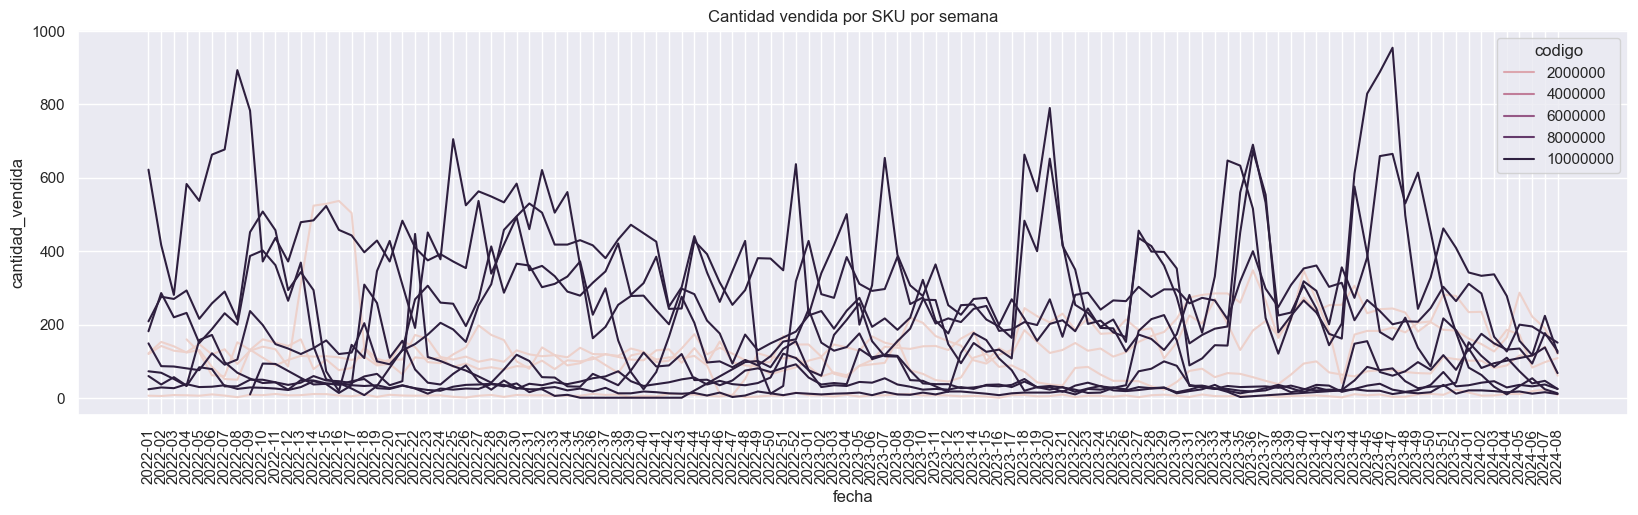

In [11]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_general, x='fecha', y='cantidad_vendida', hue='codigo')
plt.xticks(rotation=90)
plt.title("Cantidad vendida por SKU por semana")
plt.show()

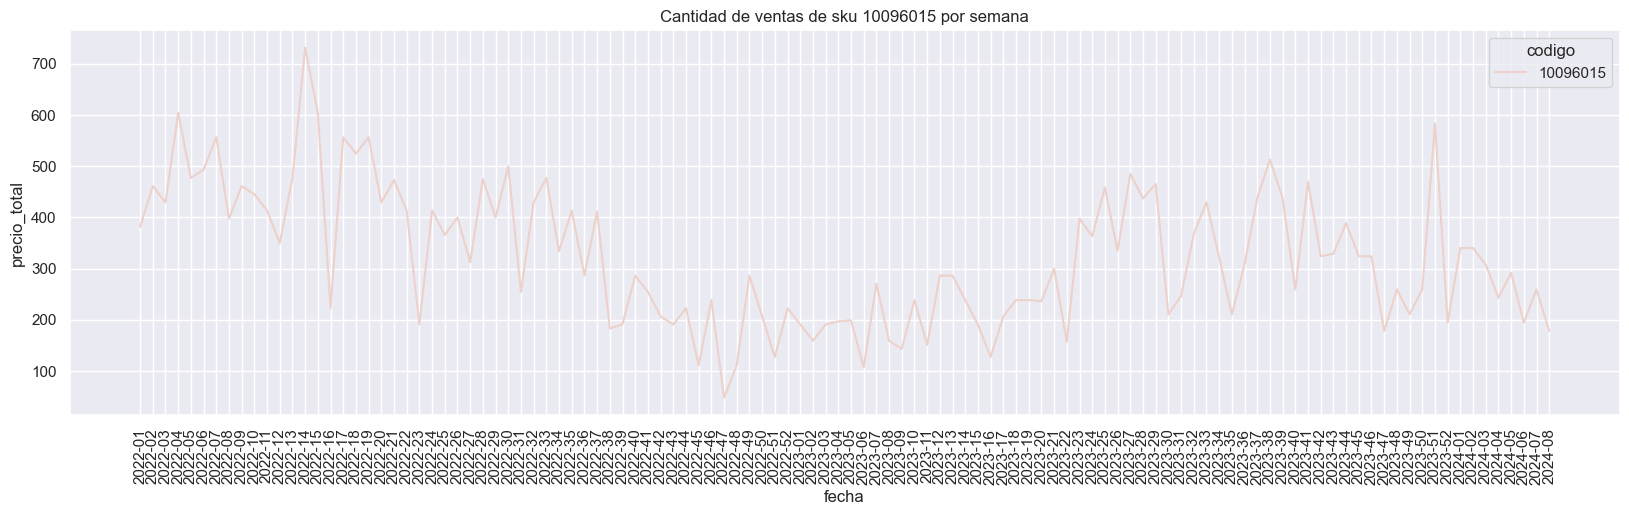

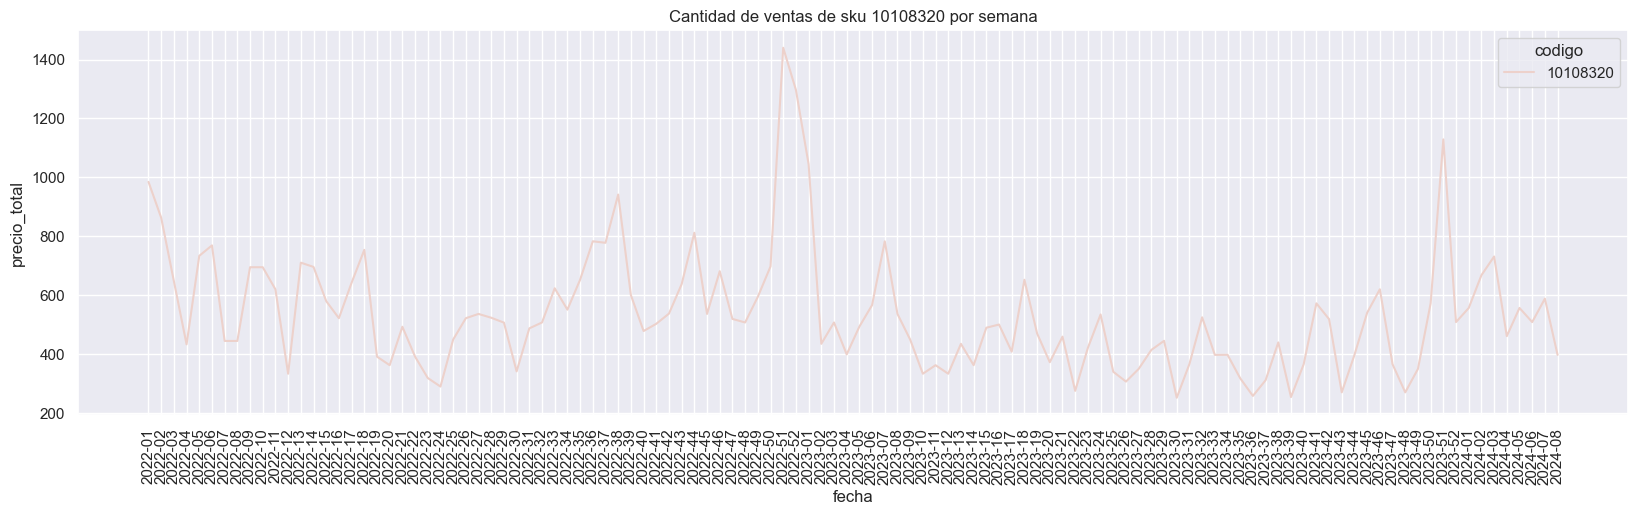

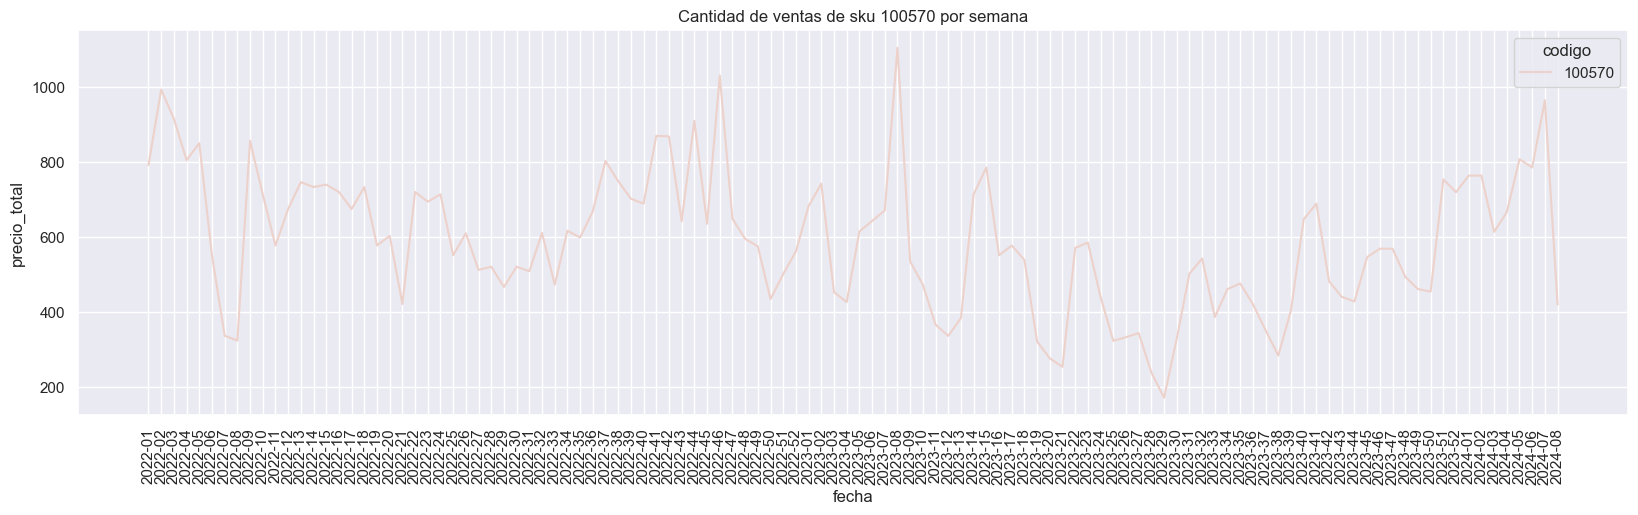

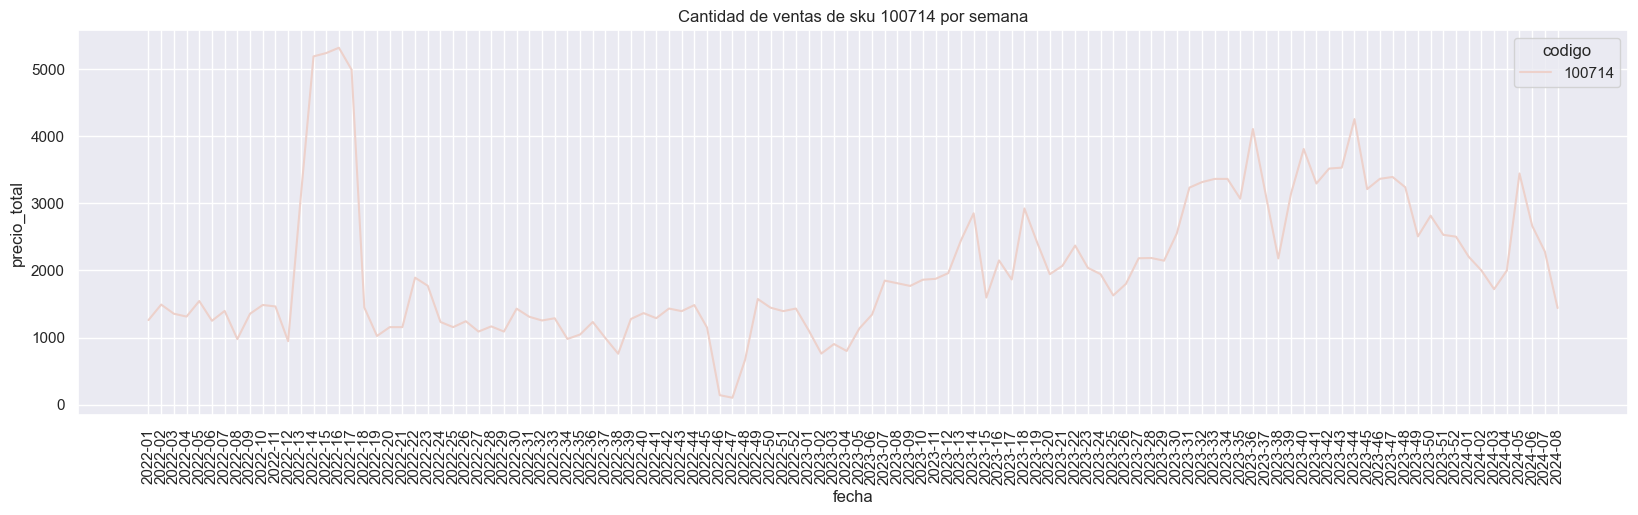

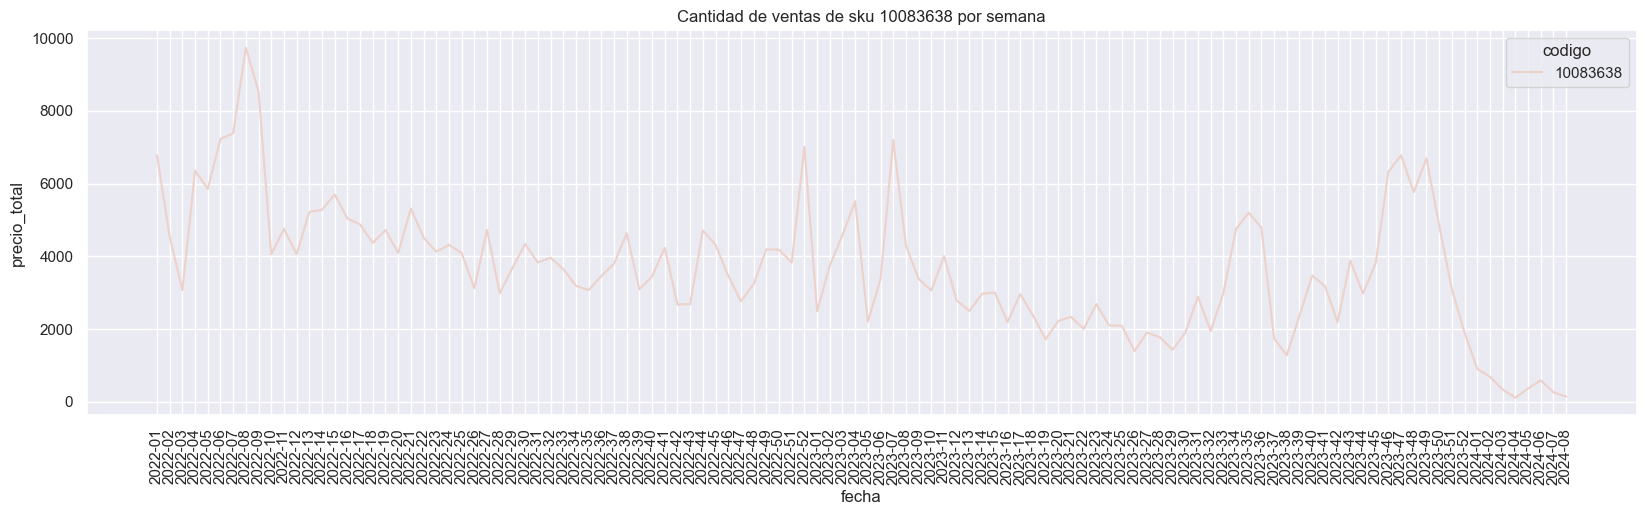

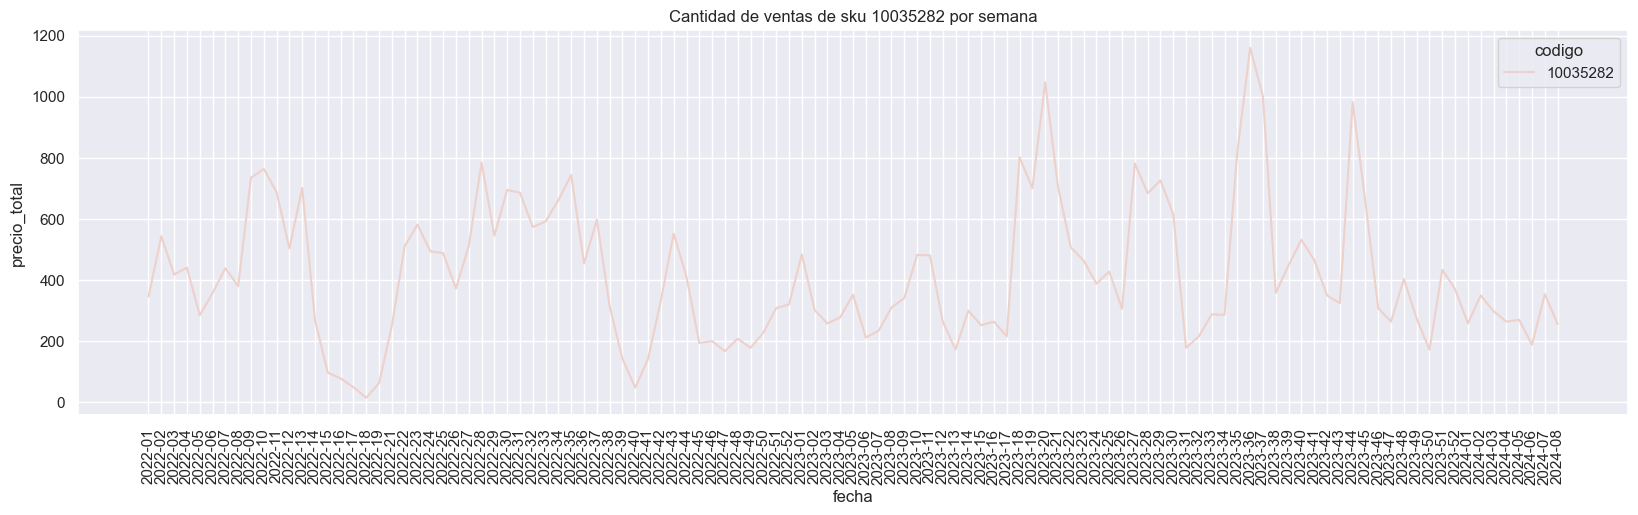

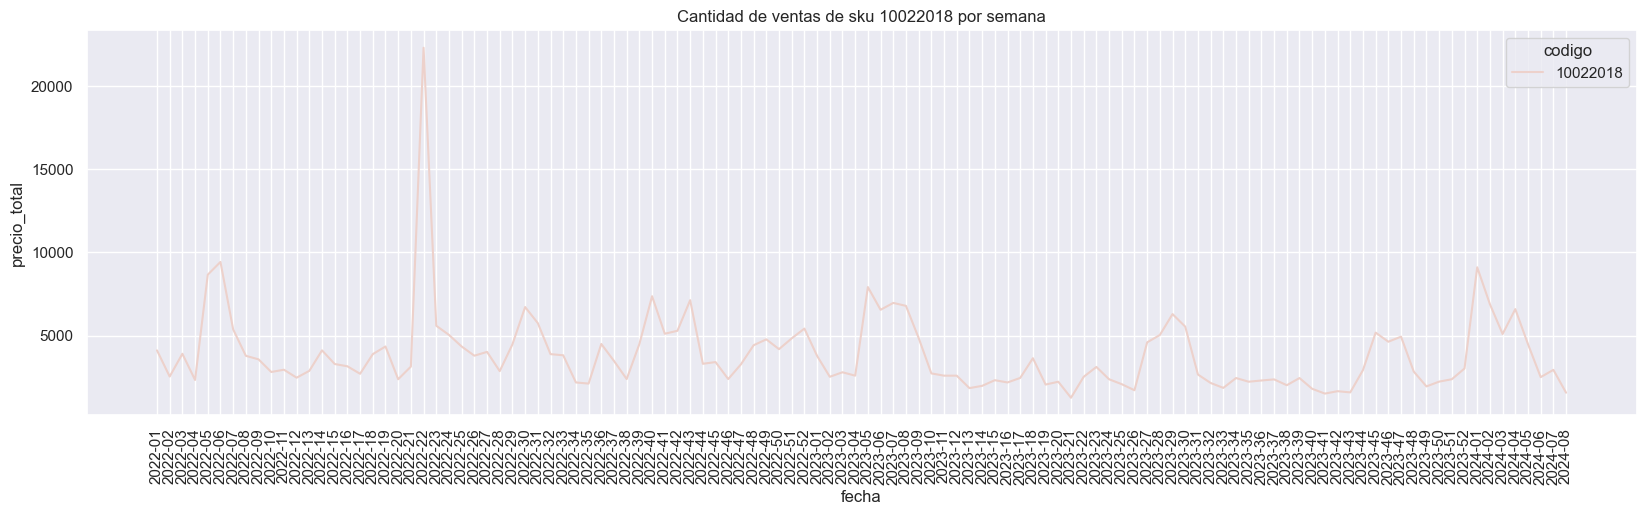

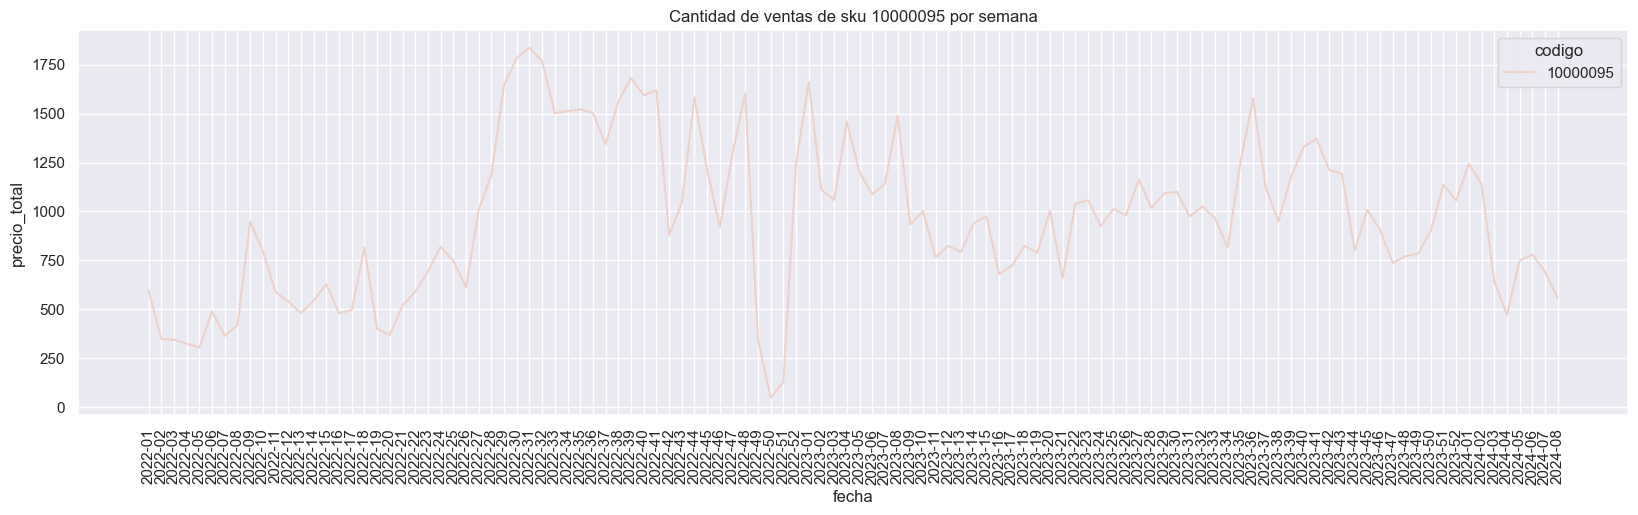

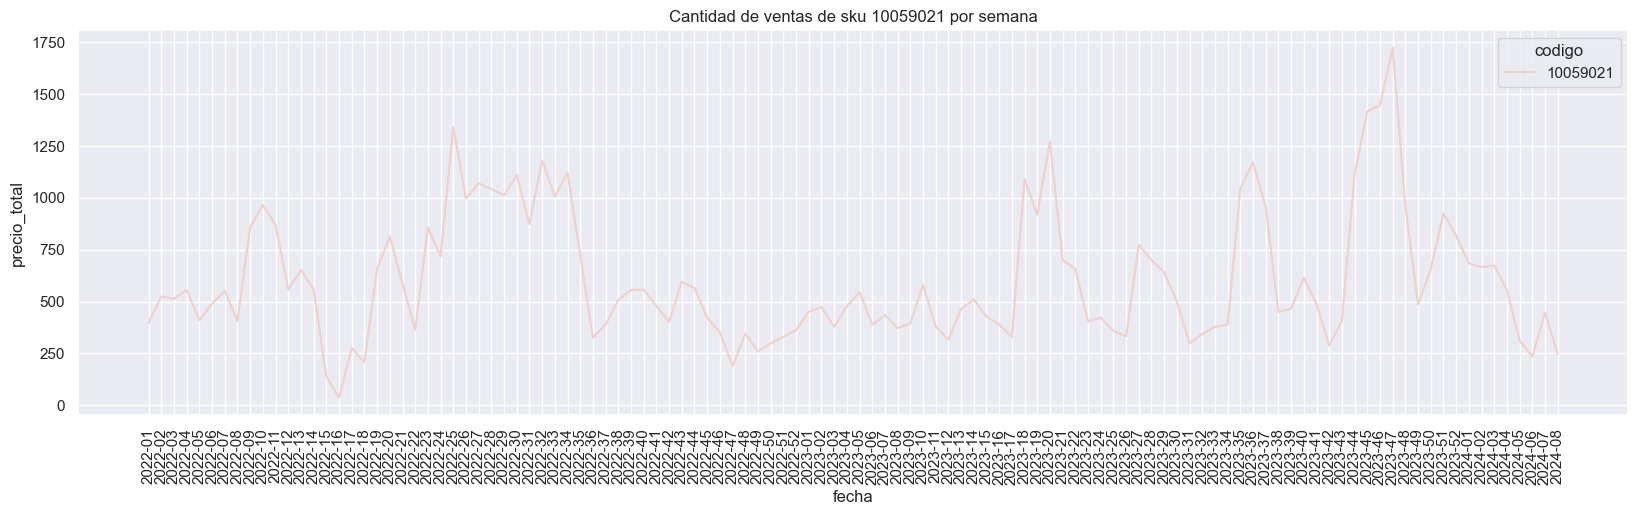

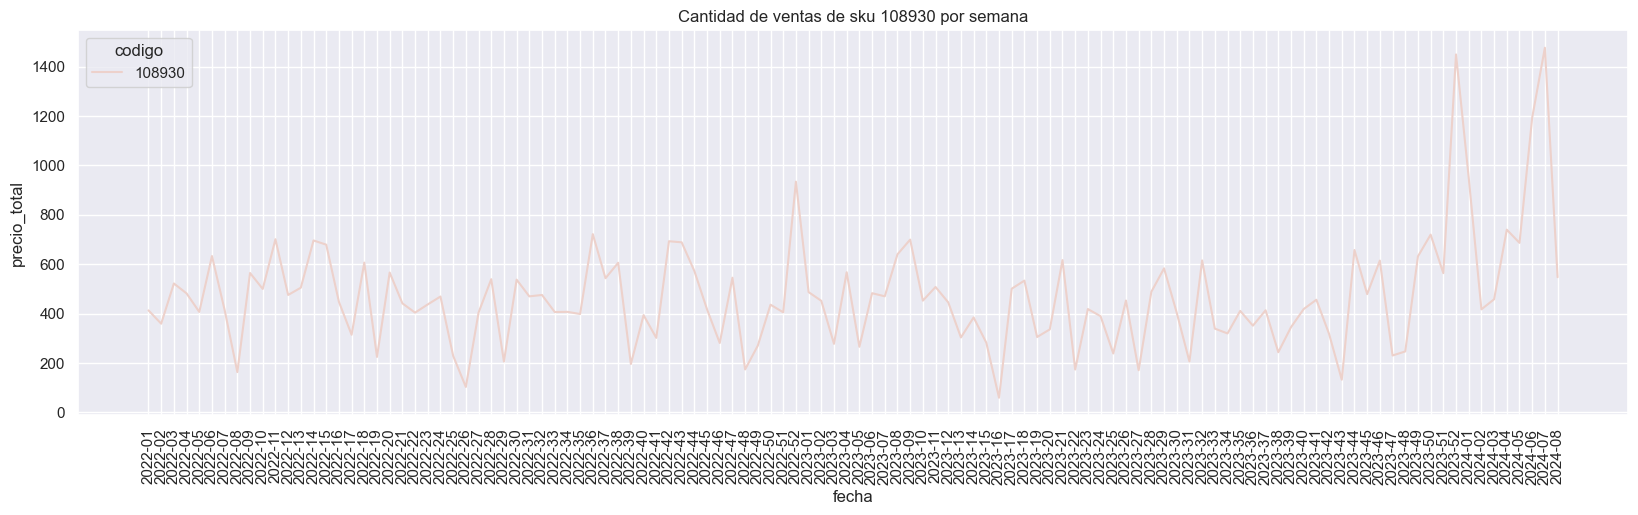

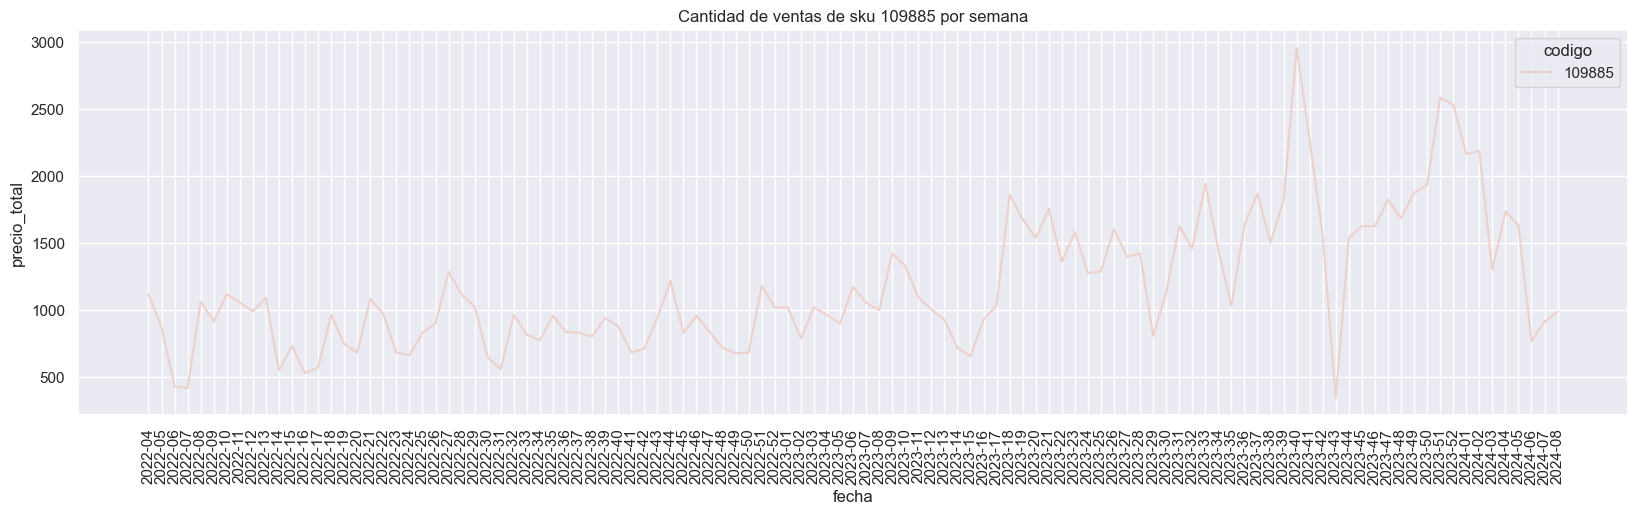

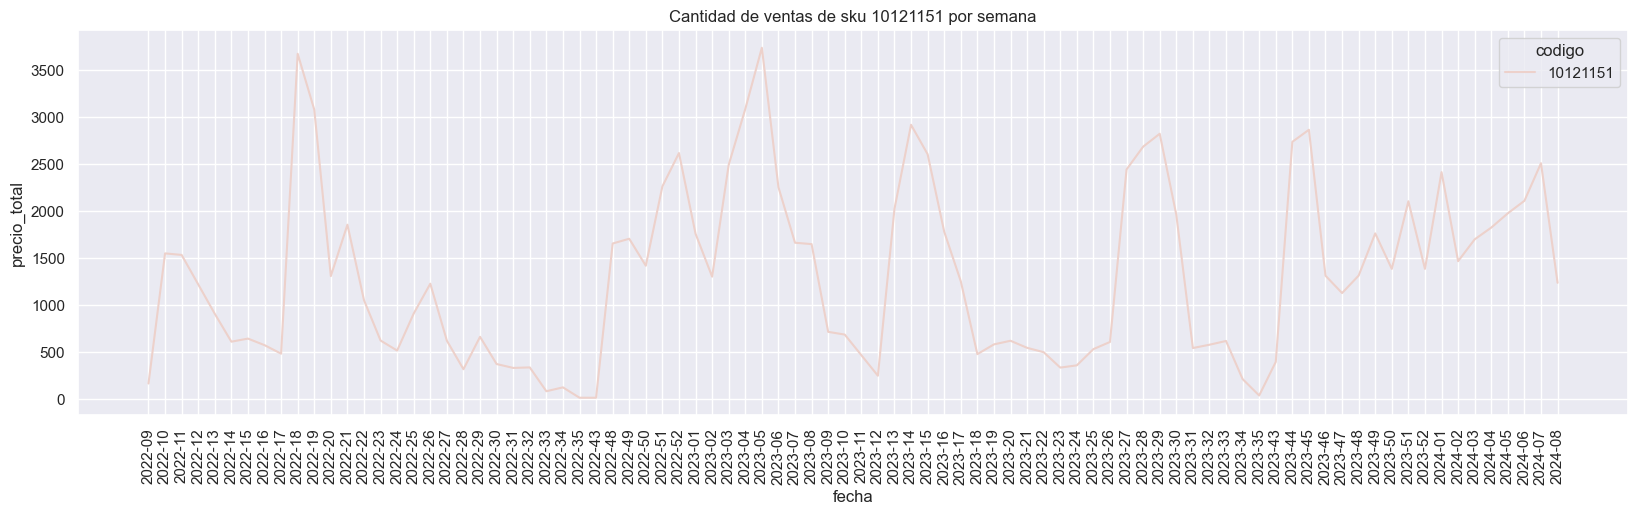

In [12]:
for sku in dict_sku.keys():
    plt.figure(figsize=(20,5))
    sns.lineplot(data=df_general[df_general['codigo']==sku], 
                 x='fecha', y='precio_total', hue='codigo',)
    plt.xticks(rotation=90)
    plt.title(f"Cantidad de ventas de sku {sku} por semana")
    plt.show()

Como el comportamiento es diferente por cada SKU (lo esperado), no se usara por le momento SARIMA para el desarrollo por optimizazión de tiempo y necesidad e regular correctamente los ordenes necesario. Es por esto que como modelo se usara a la biblioteca de Propeth, que nos ayuda bastante a automatizar la elección de estos y mas operadores de la serie.

Además en revisión la data llega a 2024-08.

In [13]:
df_general

,codigo,fecha,cantidad_vendida,precio_total,costo_total
0,100570,2022-01,122.0,793.0,695.40
1,100570,2022-02,153.0,994.5,872.10
2,100570,2022-03,141.0,916.5,803.70
3,100570,2022-04,124.0,806.0,706.80
4,100570,2022-05,131.0,851.5,746.70
...,...,...,...,...,...
1309,10121151,2024-04,102.0,1825.8,1833.96
1310,10121151,2024-05,109.0,1977.8,1959.82
1311,10121151,2024-06,116.0,2111.2,2085.68
1312,10121151,2024-07,138.0,2511.6,2481.24


Por ello, se quitara la semana 2024-08, para que este según los enunciados hasta 2024-07, y tener una semana de testeo, y hacer pronóstico para dicha semana también.

In [14]:
# Para información de la semana 2024-08 de todo los sku id
df_total_202408 = df_general[df_general['fecha']=='2024-08'].copy()

# Para información menos a la semana 2024-08
df_total = df_general[df_general['fecha']!='2024-08'].copy()


In [15]:
df_total_202408

,codigo,fecha,cantidad_vendida,precio_total,costo_total
111,100570,2024-08,61.0,420.90,347.700
223,100714,2024-08,120.0,1440.00,1200.000
335,108930,2024-08,8.7,547.23,431.955
444,109885,2024-08,109.0,990.70,839.300
556,10000095,2024-08,151.0,558.50,486.220
668,10022018,2024-08,25.0,1562.50,1592.750
779,10035282,2024-08,128.0,256.00,179.200
891,10059021,2024-08,123.0,246.00,172.200
1003,10083638,2024-08,13.0,141.70,113.490
1115,10096015,2024-08,11.0,178.20,134.200


In [16]:
df_total

,codigo,fecha,cantidad_vendida,precio_total,costo_total
0,100570,2022-01,122.0,793.0,695.40
1,100570,2022-02,153.0,994.5,872.10
2,100570,2022-03,141.0,916.5,803.70
3,100570,2022-04,124.0,806.0,706.80
4,100570,2022-05,131.0,851.5,746.70
...,...,...,...,...,...
1308,10121151,2024-03,95.0,1700.5,1708.10
1309,10121151,2024-04,102.0,1825.8,1833.96
1310,10121151,2024-05,109.0,1977.8,1959.82
1311,10121151,2024-06,116.0,2111.2,2085.68


### 1. Modelo de Predicción
Hacer un modelo de predicción de cantidades vendidas para cada uno de los SKUs (qi), y
calcular la proyección de la cantidad vendida para la siguiente semana.

Se desarrollaron funciones necesarias para el funcionamiento de los modelos desarrolado con Propthet

In [17]:
import datetime

# año-semana a datetime
def year_week_to_date(year_week):
    year, week = map(int, year_week.split('-'))
    first_day_of_year = datetime.date(year, 1, 1)
    base_week_day = first_day_of_year - datetime.timedelta(days=first_day_of_year.weekday())
    return base_week_day + datetime.timedelta(weeks=(week))

# datetime a año-semana
def date_to_year_week(date):
    if isinstance(date, str):
        date = datetime.datetime.strptime(date, "%Y-%m-%d").date()
    year = date.year
    week = date.isocalendar().week
    return f"{year}-{week:02d}"



In [18]:
from sklearn.metrics import mean_absolute_error

#  MASE (Error Absoluto Medio de Escala de Error)
def mase(actual, forecast, seasonality):
    actual_diff = np.diff(actual, n=seasonality)
    forecast_diff = np.diff(forecast, n=seasonality)
    scaled_error = np.mean(np.abs(actual_diff - forecast_diff))
    naive_error = np.mean(np.abs(actual_diff[seasonality:] - actual_diff[:-seasonality]))
    mase_value = scaled_error / naive_error
    return mase_value

# Pronóstico en el Intervalo (PI)
def pi(actual, lower_bound, upper_bound):
    within_interval = np.sum((actual >= lower_bound) & (actual <= upper_bound))
    percentage_within_interval = within_interval / len(actual)
    return percentage_within_interval

# MAPE (Error Porcentual Absoluto Medio)
def mean_absolute_porcentual_error(real, pred):
    real, pred = np.array(real), np.array(pred)
    return np.mean(np.abs((real - pred) / real)) * 100

# Metricas
def metrics(forecast, var_target):
    df = forecast.copy()
    df = df.dropna(subset=[var_target], axis=0)

    ls_mase = list()
    for s in range(1, 13):
        ls_mase.append( mase(df[var_target], df['yhat'], s) )

    pi_score = pi(df[var_target], df['yhat_lower'], df['yhat_upper'])
    mae = mean_absolute_error(df[var_target], df['yhat'])
    mape = mean_absolute_porcentual_error(df[var_target], df['yhat'])

    print(f'METRICS -> MAPE: {np.round(mape,4)}, MAE: {np.round(mae,4)}, MASE: {np.round(np.mean(ls_mase),4)}, PI: {np.round(pi_score,4)}')

    return [np.round(mape,4), np.round(mae,4), np.round(np.mean(ls_mase),4), np.round(pi_score,4)]

Ahora se crearán modelos para los diferentes sku's usando Phopeth, resaltado que por el momento para no hacer mucho desarrollo de analisis por sku, se usara toda la información (toda la serie) al algoritmo para entrenarlo (aunque se tiene codigo comentado para separacion de entrenamienot y validacion), usando las métricas de MAPE, MAE, MASE y PI para ir revisando los resultados de la serie, donde se tomara en cuenta la generación de intervalso de confianza al 80% (default por documentación). El PI es el que ayudará a verificar una correcta implementacion en base a este intervalo de confianza.

13:51:18 - cmdstanpy - INFO - Chain [1] start processing
13:51:18 - cmdstanpy - INFO - Chain [1] done processing


SKU ID: 10096015


e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


METRICS -> MAPE: 26.2037, MAE: 4.4792, MASE: 0.7073, PI: 0.8018


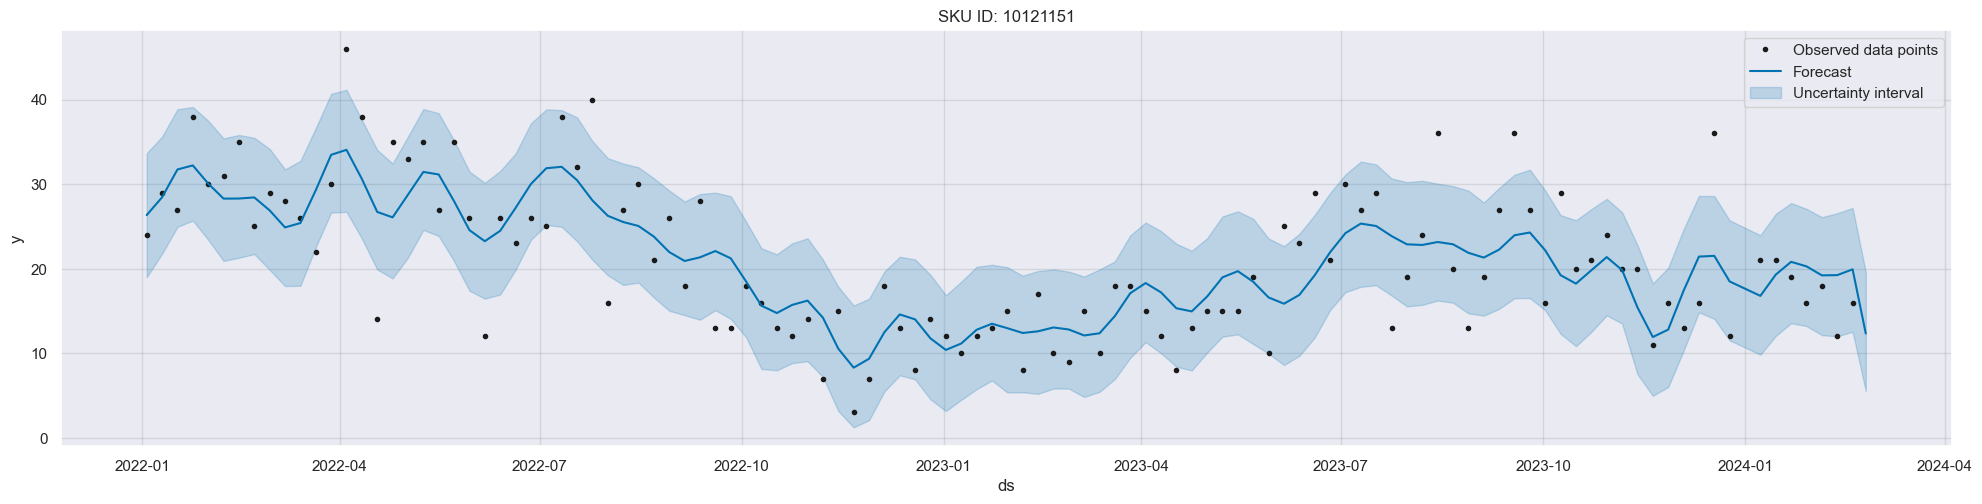

13:51:19 - cmdstanpy - INFO - Chain [1] start processing
13:51:19 - cmdstanpy - INFO - Chain [1] done processing


SKU ID: 10108320
METRICS -> MAPE: 21.9268, MAE: 7.5798, MASE: 0.7327, PI: 0.8018


e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


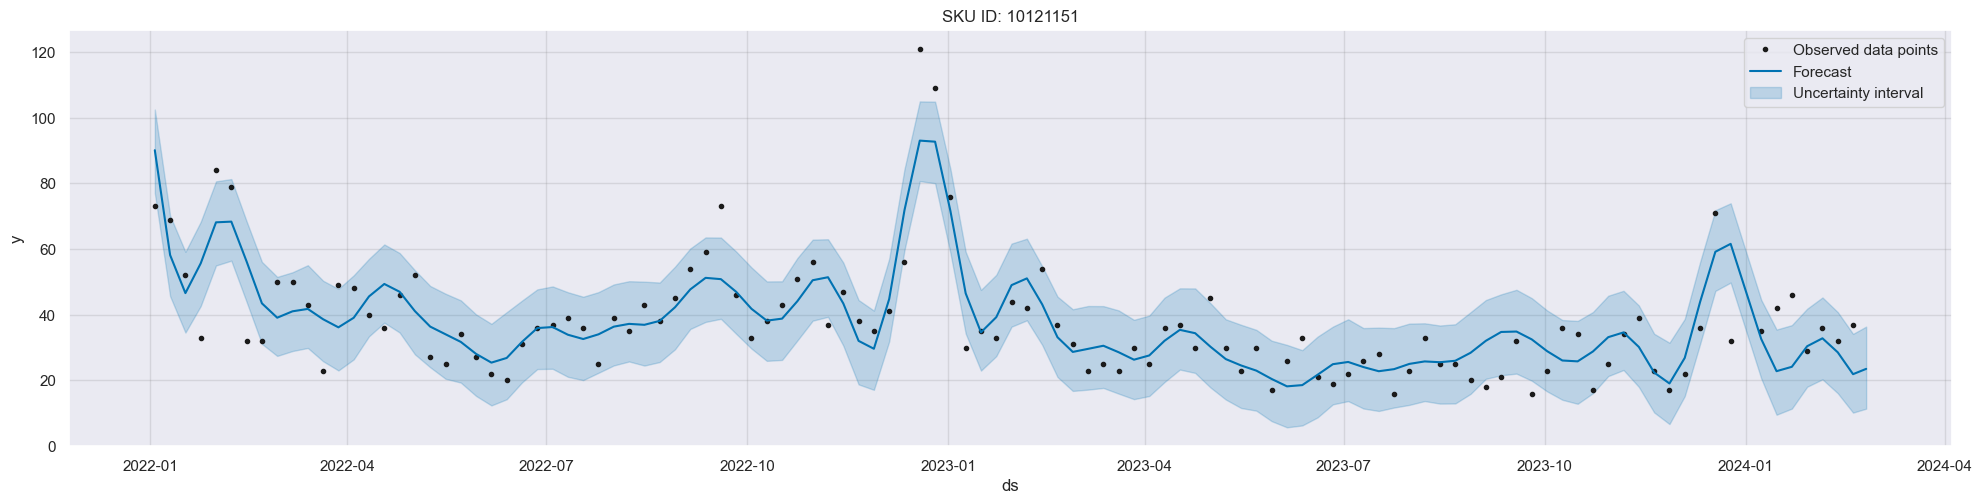

13:51:19 - cmdstanpy - INFO - Chain [1] start processing
13:51:19 - cmdstanpy - INFO - Chain [1] done processing


SKU ID: 100570
METRICS -> MAPE: 23.597, MAE: 17.1756, MASE: 0.6637, PI: 0.8559


e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


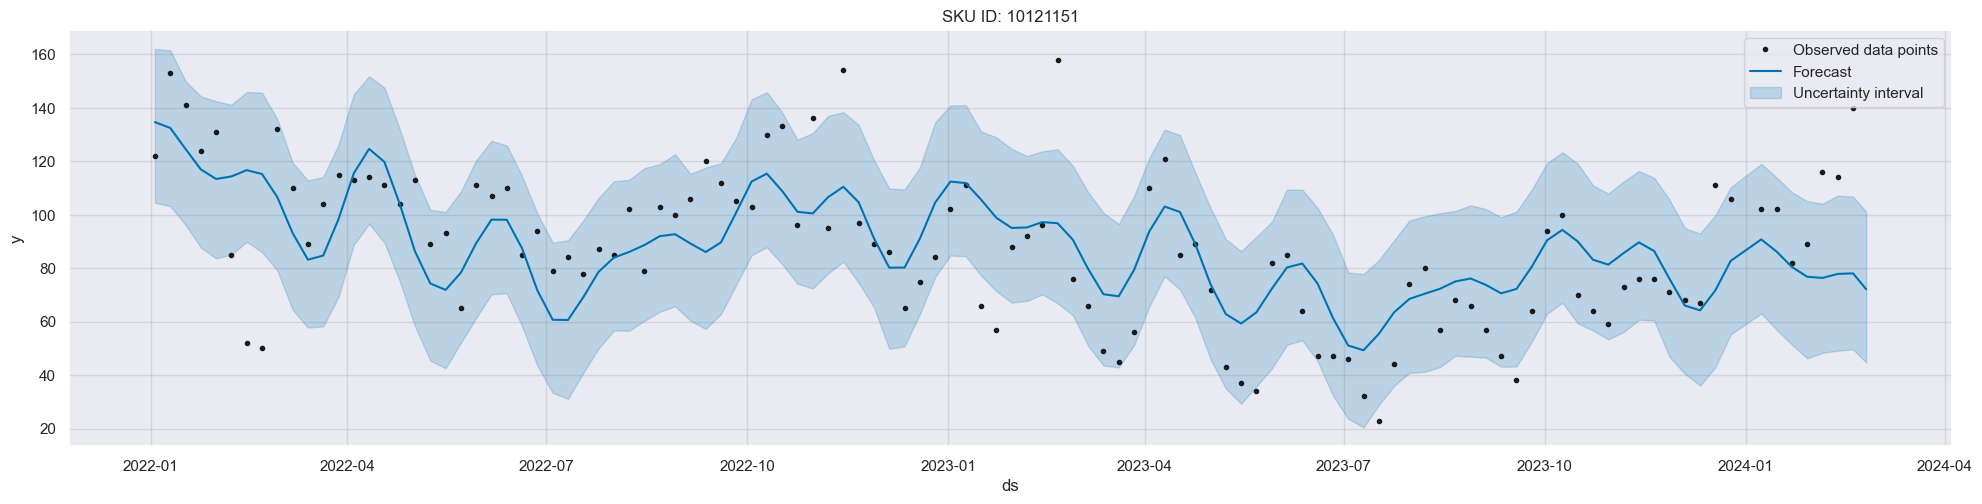

13:51:20 - cmdstanpy - INFO - Chain [1] start processing
13:51:20 - cmdstanpy - INFO - Chain [1] done processing


SKU ID: 100714
METRICS -> MAPE: 36.4401, MAE: 33.1552, MASE: 0.6981, PI: 0.8108


e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


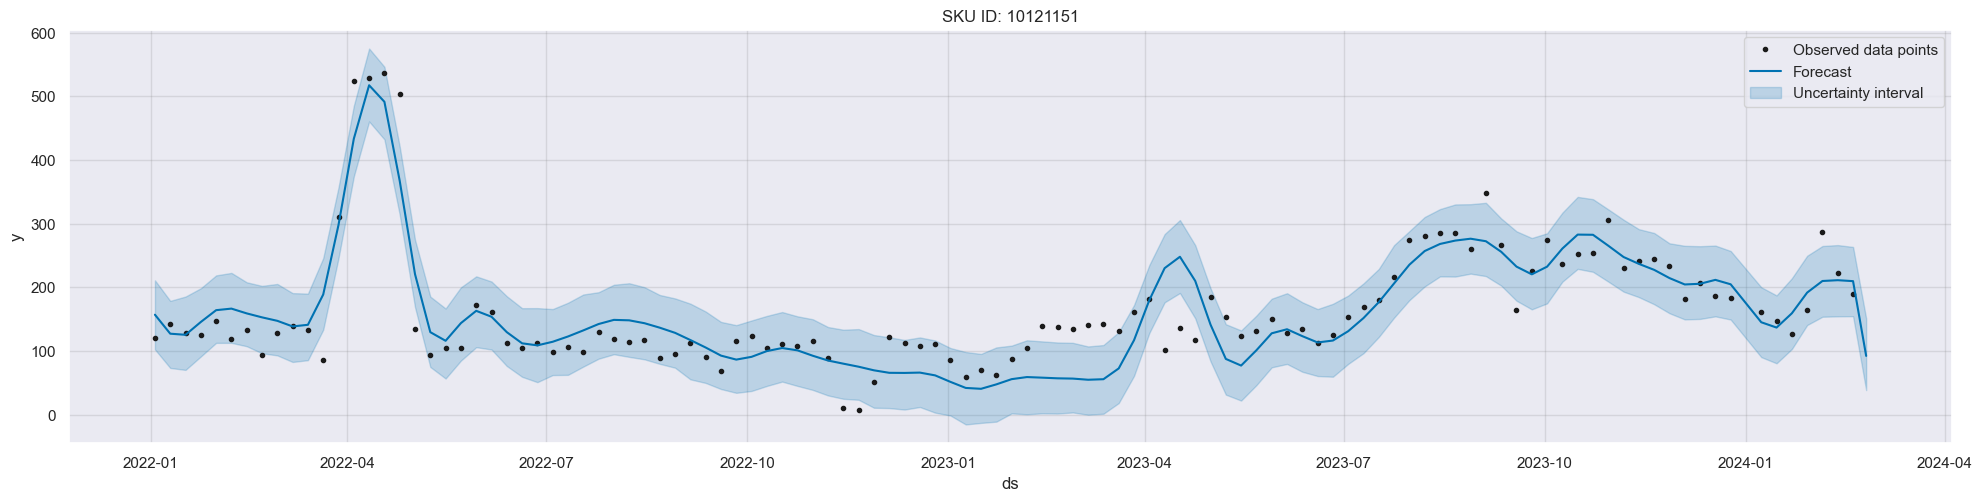

13:51:21 - cmdstanpy - INFO - Chain [1] start processing
13:51:21 - cmdstanpy - INFO - Chain [1] done processing


SKU ID: 10083638
METRICS -> MAPE: 67.0507, MAE: 99.249, MASE: 0.6826, PI: 0.8018


e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


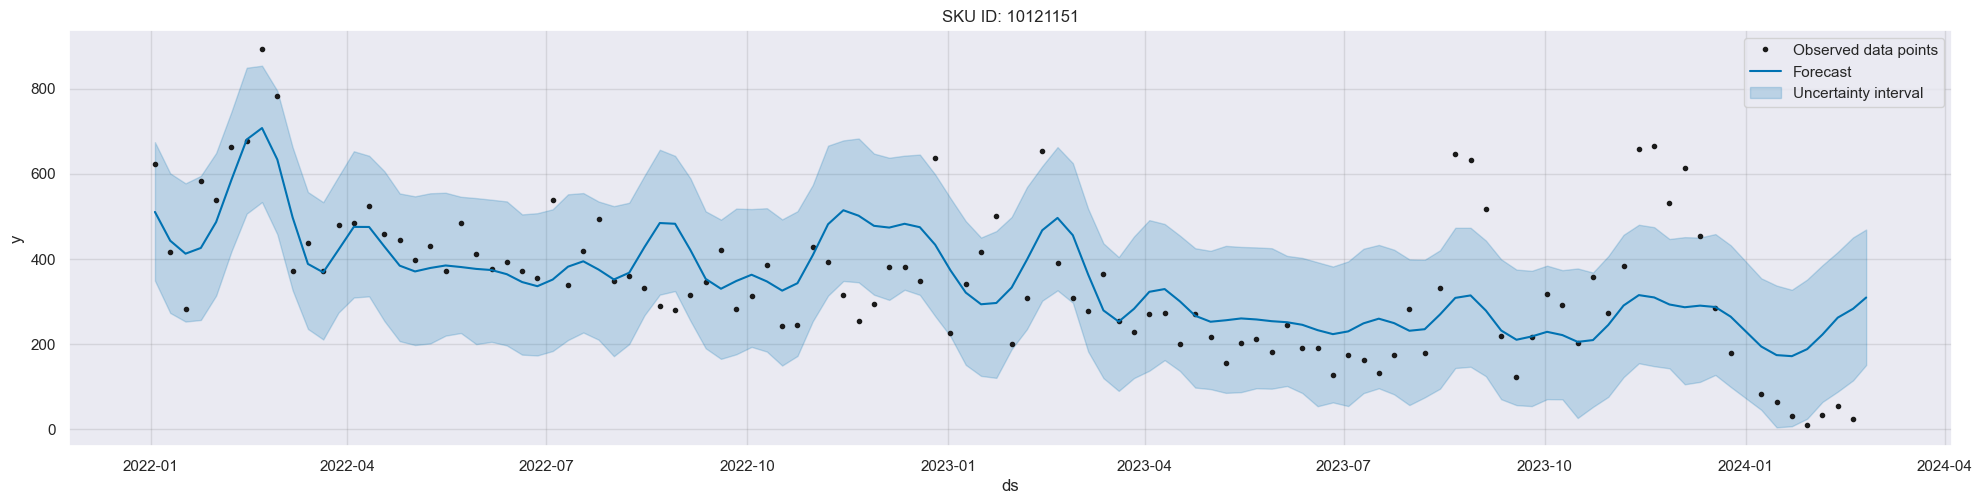

13:51:21 - cmdstanpy - INFO - Chain [1] start processing
13:51:21 - cmdstanpy - INFO - Chain [1] done processing


SKU ID: 10035282


e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


METRICS -> MAPE: 71.158, MAE: 73.8973, MASE: 0.662, PI: 0.8091


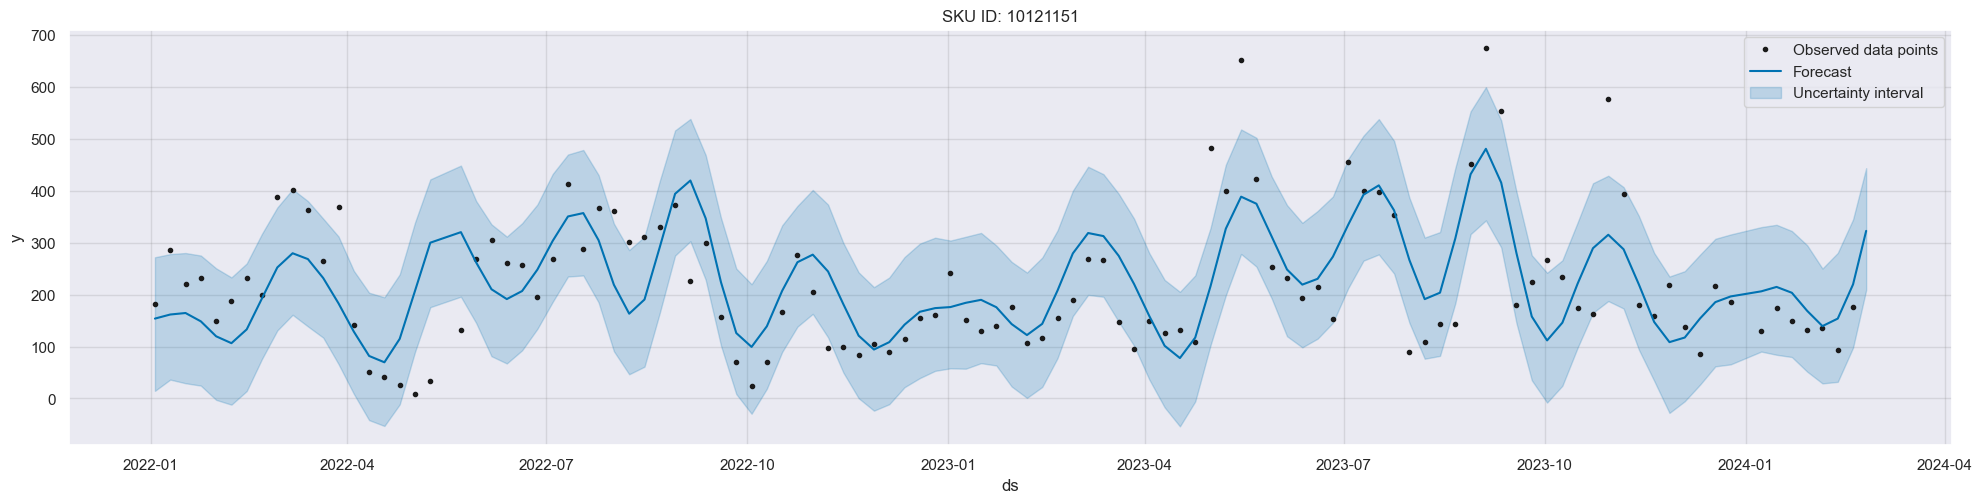

13:51:22 - cmdstanpy - INFO - Chain [1] start processing
13:51:22 - cmdstanpy - INFO - Chain [1] done processing


SKU ID: 10022018


e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


METRICS -> MAPE: 44.2711, MAE: 24.0257, MASE: 0.5952, PI: 0.9099


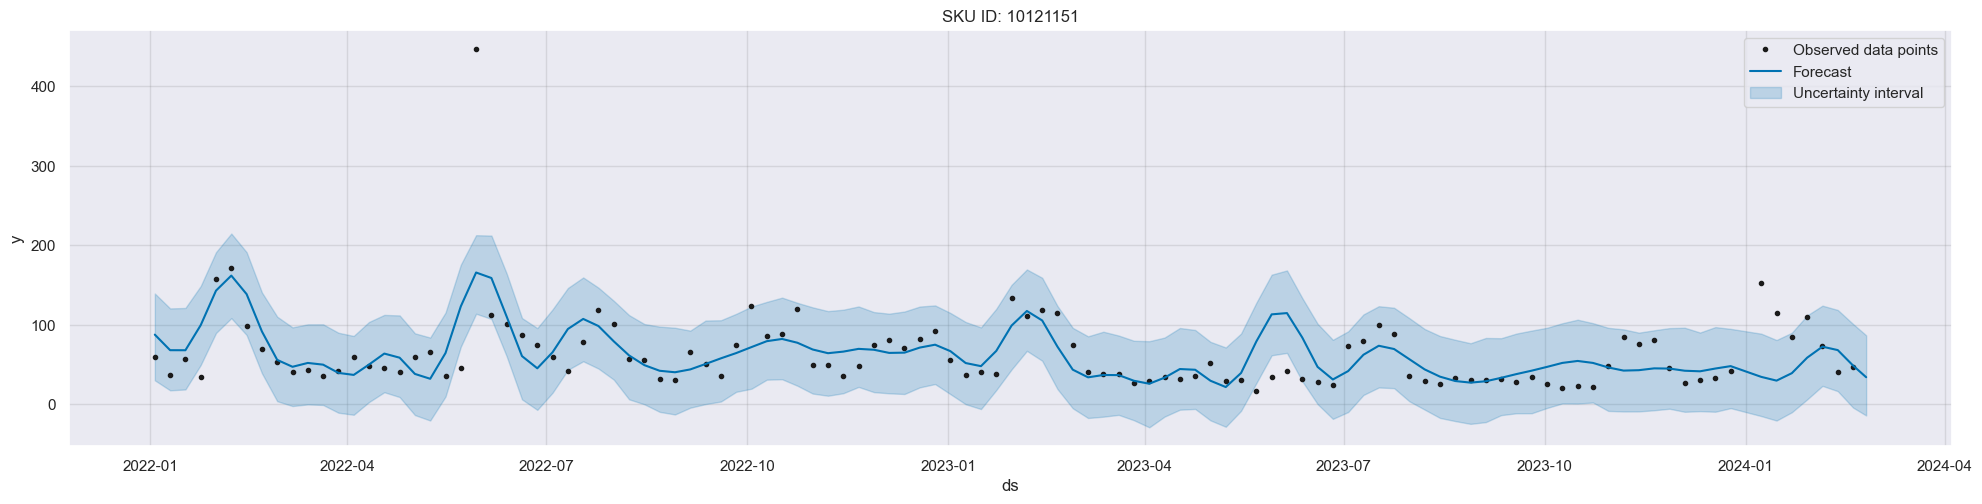

13:51:23 - cmdstanpy - INFO - Chain [1] start processing
13:51:23 - cmdstanpy - INFO - Chain [1] done processing


SKU ID: 10000095
METRICS -> MAPE: 35.6052, MAE: 46.0317, MASE: 0.6855, PI: 0.8378


e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


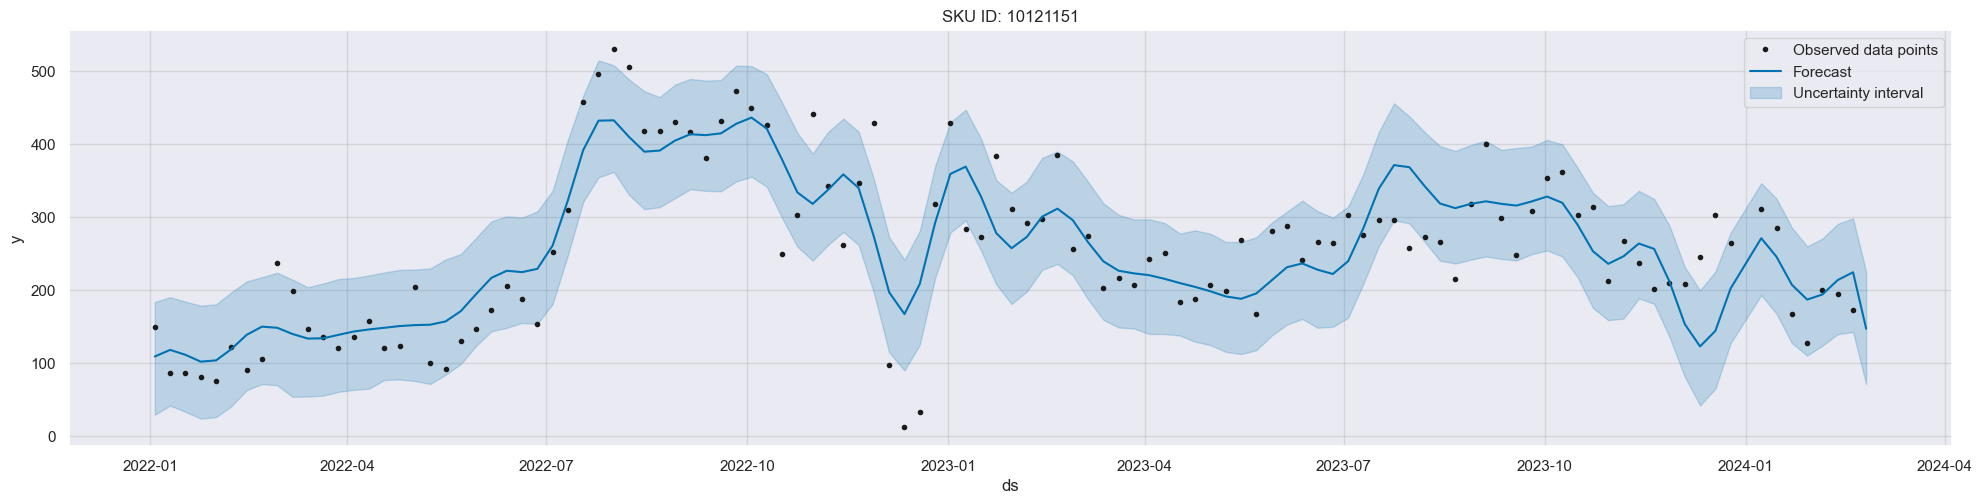

13:51:23 - cmdstanpy - INFO - Chain [1] start processing
13:51:23 - cmdstanpy - INFO - Chain [1] done processing


SKU ID: 10059021


e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


METRICS -> MAPE: 47.1371, MAE: 109.2864, MASE: 0.6418, PI: 0.8198


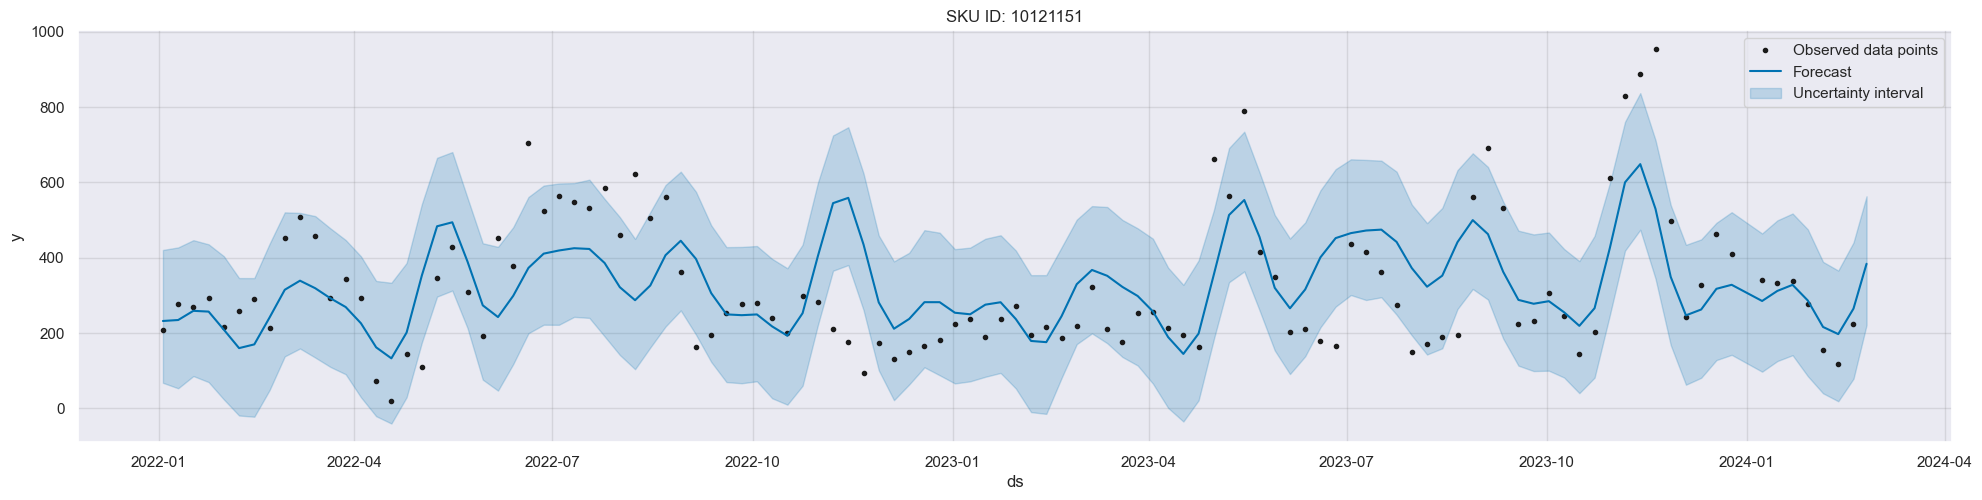

13:51:24 - cmdstanpy - INFO - Chain [1] start processing
13:51:24 - cmdstanpy - INFO - Chain [1] done processing


SKU ID: 108930
METRICS -> MAPE: 43.7205, MAE: 2.3638, MASE: 0.7018, PI: 0.8018


e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


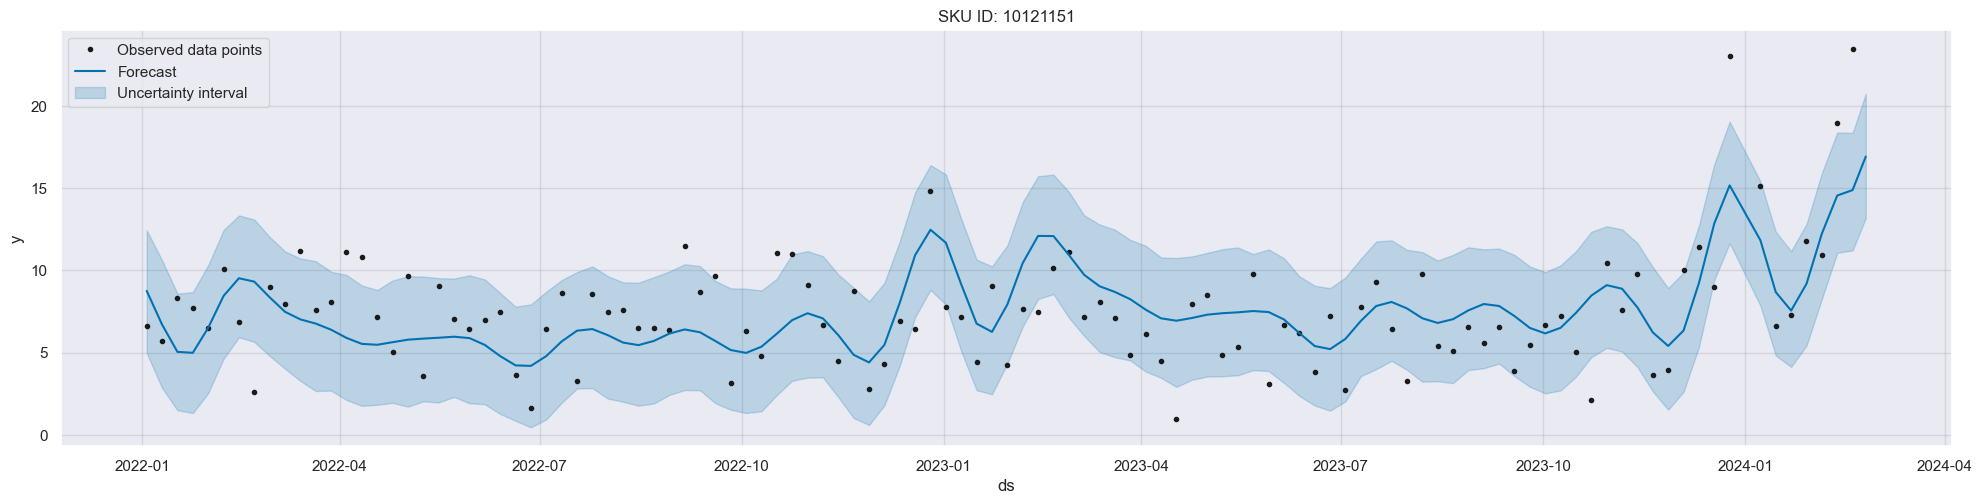

13:51:25 - cmdstanpy - INFO - Chain [1] start processing
13:51:25 - cmdstanpy - INFO - Chain [1] done processing


SKU ID: 109885
METRICS -> MAPE: 20.6449, MAE: 27.1156, MASE: 0.726, PI: 0.7685


e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


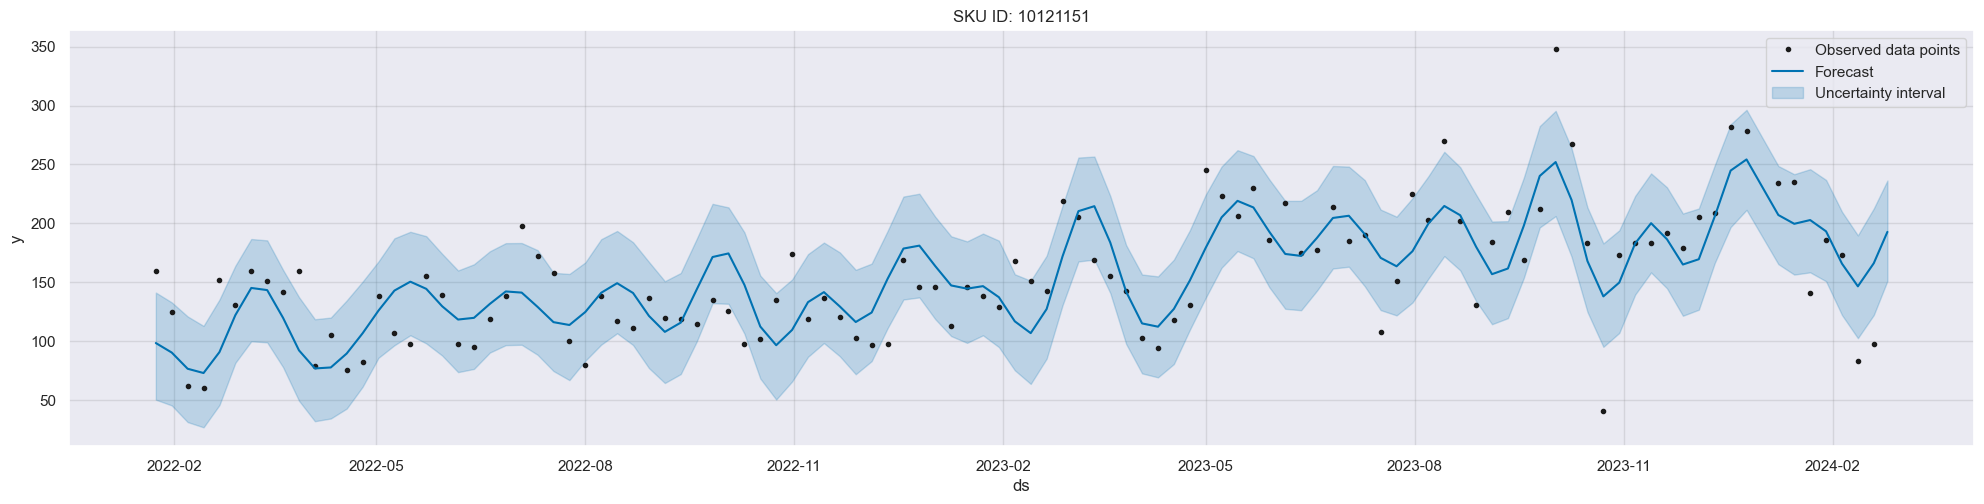

13:51:25 - cmdstanpy - INFO - Chain [1] start processing


SKU ID: 10121151


13:51:26 - cmdstanpy - INFO - Chain [1] done processing
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Proyectos\pricelab_challenge\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


METRICS -> MAPE: 123.4121, MAE: 38.6272, MASE: 0.7041, PI: 0.8118


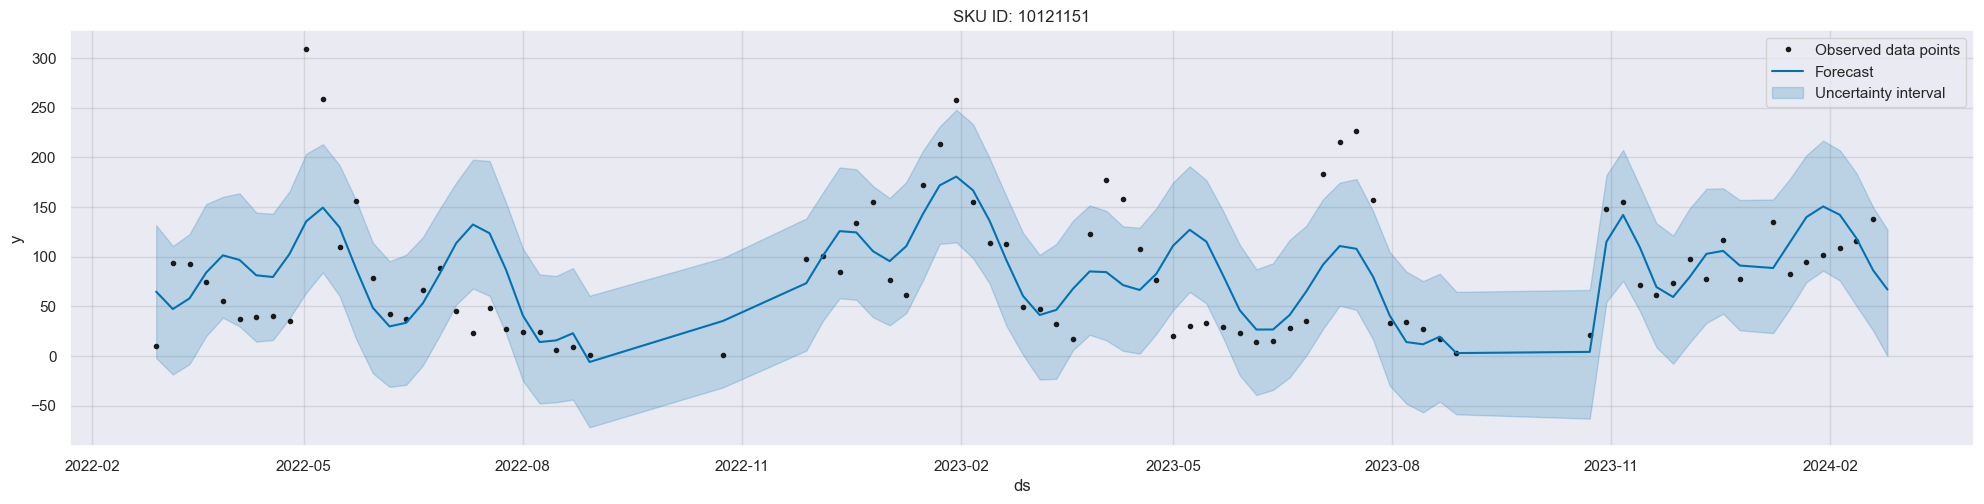

In [38]:
# Creacion de modelos por SKU
models = {}
sku_next_week_df = {}
sku_next_week_full = {}
for sku_id in dict_sku.keys():
    print('=====================================================================================')
    print('SKU ID:', sku_id)
    data_sku = df_total[df_total['codigo']==sku_id].copy()
    
    data_sku['date_formatted'] = data_sku['fecha'].apply(year_week_to_date)
    
    # train = data_sku[:int(0.80*(len(data_sku)))]
    # valid = data_sku[int(0.80*(len(data_sku))):]
    
    # valid['date_formatted'] = valid['fecha'].apply(year_week_to_date)
    
    # train_prophet = pd.DataFrame()
    # train_prophet['ds'] = train['date_formatted']
    # train_prophet['y'] = train['cantidad_vendida']
    
    # Entremiento del modelo
    train_prophet = pd.DataFrame()
    train_prophet['ds'] = data_sku['date_formatted']
    train_prophet['y'] = data_sku['cantidad_vendida']    
    
    # Modelo Prophet con estacionalidades anual, semanal y diaria (ya que los datos son semanales)
    model = Prophet(yearly_seasonality=True,
                    weekly_seasonality=True,
                    daily_seasonality=True, seasonality_mode = 'multiplicative')
    model.fit(train_prophet)
    
    # Predicción de la siguiente semana
    future = model.make_future_dataframe(periods = 1, freq = 'w') 
    forecast = model.predict(future)

    forecast_final = forecast.set_index('ds')
    forecast_final['cantidad_vendida'] = data_sku.set_index(['date_formatted'])['cantidad_vendida']

    # Métricas, se usaron las métricas de MAPE, MAE, MASE y PI
    mt = metrics(forecast_final, 'cantidad_vendida')
    
    # Plot de los resultados del modelo
    fig = model.plot(forecast,figsize=(20, 5), include_legend=True)
    # plt.plot(valid.set_index(['date_formatted'])['cantidad_vendida'], label='Valid', color = 'red', linewidth = 2)
    plt.title(f'SKU ID: {sku}')
    plt.show()
    
    # Guardar resultados
    pred_next_week = forecast_final[['yhat','yhat_lower','yhat_upper']].round(0).iloc[[-1]].T.to_dict()
    next_timestamp = list(pred_next_week.keys())[0]
    sku_next_week_df[sku_id] = {
                                'fecha': date_to_year_week(next_timestamp),
                                'pred': pred_next_week[next_timestamp]['yhat'],
                                'pred_min': pred_next_week[next_timestamp]['yhat_lower'],
                                'pred_max': pred_next_week[next_timestamp]['yhat_upper']
                            }
    sku_next_week_full[sku_id] = {
                                'fecha': date_to_year_week(next_timestamp),
                                'pred': pred_next_week[next_timestamp]['yhat'],
                                'pred_min': pred_next_week[next_timestamp]['yhat_lower'],
                                'pred_max': pred_next_week[next_timestamp]['yhat_upper'],
                                'meta-data': {
                                    'train-metrics': {
                                        'mape': mt[0],
                                        'mae': mt[1],
                                        'mase': mt[2],
                                        'pi': mt[3]
                                    }
                                }
                            }
    models[sku_id] = model


Resultado final de predicción para la semana 2024-09

In [40]:
df_real = df_total_202408.set_index('codigo')[['cantidad_vendida']]
df_real.columns = ['cantidad_real']

In [41]:
# Predicciones de sku's
resultado1 = pd.DataFrame(sku_next_week_df).T
resultado1.index.name = 'codigo'

# Ingresar nombres de los skus
name_skus_df = pd.DataFrame(dict_sku,index=[0]).T
name_skus_df.index.name = 'codigo'
name_skus_df.columns = ['producto']

resultado1 = pd.concat([name_skus_df, resultado1],axis=1)

resultado1 = pd.concat([resultado1, df_real],axis=1)[['producto','fecha','cantidad_real','pred','pred_min','pred_max']]
resultado1['cuplimiento_modelo'] = (resultado1['cantidad_real'] >= resultado1['pred_min']) & (resultado1['cantidad_real'] <= resultado1['pred_max'])
resultado1['cuplimiento_modelo'] = resultado1['cuplimiento_modelo'].apply(lambda x: 'Cumple' if x else 'No Cumple')
resultado1

,producto,fecha,cantidad_real,pred,pred_min,pred_max,cuplimiento_modelo
codigo,,,,,,,
10096015,NESTLE CLASSIC MILK 80G,2024-08,11.0,12.0,6.0,20.0,Cumple
10108320,CHOCOLATE SUBLIME CLASICO 100GR,2024-08,25.0,24.0,11.0,36.0,Cumple
100570,ALIM. BEB.DE SOYA BANA,2024-08,61.0,72.0,45.0,101.0,Cumple
100714,HUEVO ROLON M.CORTADO 12U,2024-08,120.0,92.0,39.0,151.0,Cumple
10083638,CERVEZA HUARI MIEL 330ML,2024-08,13.0,309.0,150.0,469.0,No Cumple
10035282,JUGO PIL PINA ETRA 150ML,2024-08,128.0,323.0,209.0,443.0,No Cumple
10022018,PAPEL HIG CONFORT 12UN,2024-08,25.0,34.0,-14.0,87.0,Cumple
10000095,GASEOSA PEPSI 500ML,2024-08,151.0,147.0,71.0,225.0,Cumple
10059021,JUGO PIL MANZ CLASIC TETR,2024-08,123.0,384.0,221.0,563.0,No Cumple


De denotan las diferentes unidades demandas para la semana 2024-08 en la columna 'pred', resaltando intervalos de confianza, para ver si la estimación cumple o no cumple con lo real directamente. Por ello se tiene un cumplimiento entre intervalso de confianza de 7/12 SKU's. Finalamente se tiene un diccionario con metadata de metricas del modelo para contrastar (no en la tabla final). 

### 2. Estimación de Revenue
Escribir un algoritmo de maximización de revenue que le permita encontrar el vector de precios óptimos. Incorpore las restricciones que considere pertinentes. 

In [22]:
df_res2 = df_total.copy()

In [23]:
# Cálculo del precio promedio y costo promedio por unidad
df_res2['precio_promedio'] = df_res2['precio_total'] / df_res2['cantidad_vendida']
df_res2['costo_promedio'] = df_res2['costo_total'] / df_res2['cantidad_vendida']

In [24]:
df_res2

,codigo,fecha,cantidad_vendida,precio_total,costo_total,precio_promedio,costo_promedio
0,100570,2022-01,122.0,793.0,695.40,6.500000,5.70
1,100570,2022-02,153.0,994.5,872.10,6.500000,5.70
2,100570,2022-03,141.0,916.5,803.70,6.500000,5.70
3,100570,2022-04,124.0,806.0,706.80,6.500000,5.70
4,100570,2022-05,131.0,851.5,746.70,6.500000,5.70
...,...,...,...,...,...,...,...
1308,10121151,2024-03,95.0,1700.5,1708.10,17.900000,17.98
1309,10121151,2024-04,102.0,1825.8,1833.96,17.900000,17.98
1310,10121151,2024-05,109.0,1977.8,1959.82,18.144954,17.98
1311,10121151,2024-06,116.0,2111.2,2085.68,18.200000,17.98


Se usará un modelo de estimación de demanda simple, usando una regresión Lineal, asumiendo linealidad entre el precio promedio y la cantidad vendida semanal.

Por el mismo enunciado, se asume que el revenue es la cantidad * (funcion del precio), por lo que la función del precio más simple es: precio - costo, por lo que la formula general sera: cantidad_vendida * (precio - costo), y la optimización se dará un método de descenso de gradiente.

In [25]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression


precios_optimos = {}
# Desarrollarlo para cada SKU ID
for sku_id in dict_sku.keys():
    print('=====================================================================================')
    print('SKU ID:', sku_id)
    data_sku = df_res2[df_res2['codigo']==sku_id].copy()

    # Se puede hacer un vector de precios 
    # temporal: basado en precios por cumulos de tiempo.
    # algoritmico: basado en uso de algoritmos de estimación de demanda
    # Para este caso se usar el temporal usado solo 1 algoritmo (regresion lineal),
    # para eso se crearan cortes de tiempo del sku id (4 para tener un vector de 4 precios)
    data_sku['corte'] = pd.cut(data_sku.index, 4, labels=False) 
    precios_vect = []
    for cuartil in data_sku['corte'].unique():
        subset = data_sku[data_sku['corte'] == cuartil]
        # Preparar los datos para el modelo de regresión
        X = subset[['precio_promedio']].values
        y = subset['cantidad_vendida'].values

        # Ajustar el modelo lineal
        modelo_demanda = LinearRegression().fit(X, y)
        a, b = modelo_demanda.intercept_, modelo_demanda.coef_[0]

        # Precio Promedio
        precio_inicial = [subset['precio_promedio'].mean()]

        # Costo promedio
        costo_promedio = subset['costo_promedio'].mean()

        # Restricciones: precio debe ser positivo
        bounds = [(0.01, max(subset['precio_promedio']))]

        # Fuincion objetivo
        def revenue_to_maximize(price):
            cantidad = a - b * price
            costo_unitario = np.mean(subset['costo_total'] / subset['cantidad_vendida'])  # Promedio de costo unitario
            revenue = (price - costo_unitario) * cantidad
            return -revenue  # Negativo porque minimize busca minimizar

        # Optimización del precio usando la función minimize de scipy que usa el método de Nelder-Mead
        result = minimize(revenue_to_maximize, x0=[np.mean(subset['precio_promedio'])], bounds=bounds)

        precios_vect.append(result.x[0]) 
    precios_optimos[sku_id] = precios_vect
    print(f'Vector de Precios: {precios_vect}')
    


SKU ID: 10096015
Vector de Precios: [15.900000000000002, 15.900000000000002, 3.301757288180025, 16.2]
SKU ID: 10108320
Vector de Precios: [14.5, 14.5, 16.2, 3.402592038824686]
SKU ID: 100570
Vector de Precios: [0.356493612770946, 7.5, 7.5, 7.5]
SKU ID: 100714
Vector de Precios: [11.0, 12.900000000000002, 15.800000000000002, 13.900000000000002]
SKU ID: 10083638
Vector de Precios: [6.775190407801066, 11.0, 11.0, 10.900000000000002]
SKU ID: 10035282
Vector de Precios: [0.01, 2.0, 2.0, 2.0]
SKU ID: 10022018
Vector de Precios: [68.5, 68.1, 74.10000000000001, 74.10000000000001]
SKU ID: 10000095
Vector de Precios: [4.0, 3.9583333333333335, 3.9806763285024154, 0.7694622272409491]
SKU ID: 10059021
Vector de Precios: [0.01, 2.0, 2.0, 2.0]
SKU ID: 108930
Vector de Precios: [14.090804577188566, 0.01, 0.02567923802339938, 0.01]
SKU ID: 109885
Vector de Precios: [7.0, 1.0408120754984262, 7.9, 9.5]
SKU ID: 10121151
Vector de Precios: [16.5, 19.661816000606862, 23.9, 6.159708466288411]


In [26]:
# Vector de Precios óptimos
result2 = pd.DataFrame(precios_optimos).T
result2.index.name = 'codigo'
result2.columns = ['precio_unitario_vec_1','precio_unitario_vec_2',
                   'precio_unitario_vec_3','precio_unitario_vec_4']
result2

,precio_unitario_vec_1,precio_unitario_vec_2,precio_unitario_vec_3,precio_unitario_vec_4
codigo,,,,
10096015,15.900000,15.900000,3.301757,16.200000
10108320,14.500000,14.500000,16.200000,3.402592
100570,0.356494,7.500000,7.500000,7.500000
100714,11.000000,12.900000,15.800000,13.900000
10083638,6.775190,11.000000,11.000000,10.900000
10035282,0.010000,2.000000,2.000000,2.000000
10022018,68.500000,68.100000,74.100000,74.100000
10000095,4.000000,3.958333,3.980676,0.769462
10059021,0.010000,2.000000,2.000000,2.000000


Se generaron vectores de precios optimos para cada SKU, usando 4 cortes temporales, usando el método Nelder-Mead como optimizador.

### 3. Estimación de Incremento por Vector de Precios
Realice una estimación del incremento en revenue en la semana 8 resultado de aplicar la
recomendación de precios en la pregunta anterior.

Para este caso, se hara la comparación del incremento o decremento (precio_total - precio_por_max_vector_total).

In [27]:
# El revenue solo sera calculado para 1 semana directamente
resultado3 = pd.concat([df_total_202408.set_index('codigo'), result2],axis=1)

In [28]:
# Calculo por cada vector unitario
resultado3['precio_total_optimo_1'] = resultado3['precio_unitario_vec_1'] * resultado3['cantidad_vendida']
resultado3['precio_total_optimo_2'] = resultado3['precio_unitario_vec_2'] * resultado3['cantidad_vendida']
resultado3['precio_total_optimo_3'] = resultado3['precio_unitario_vec_3'] * resultado3['cantidad_vendida']
resultado3['precio_total_optimo_4'] = resultado3['precio_unitario_vec_4'] * resultado3['cantidad_vendida']

In [29]:
# Para sacar el maximo revenue, se 
resultado3['precio_total_optimo_max'] = resultado3[['precio_total_optimo_1','precio_total_optimo_2','precio_total_optimo_3','precio_total_optimo_4']].max(axis=1)

In [30]:
resultado3['precio_ant - precio_optim'] = resultado3['precio_total_optimo_max'] - resultado3['precio_total']
resultado3['desc'] = resultado3['precio_ant - precio_optim'].apply(lambda x: '-' if x == 0 else 'incremento' if x > 0 else 'decremento')

In [31]:
# Ingresar nombres de los skus
name_skus_df = pd.DataFrame(dict_sku,index=[0]).T
name_skus_df.index.name = 'codigo'
name_skus_df.columns = ['producto']

resultado3 = pd.concat([resultado3, name_skus_df],axis=1)

In [32]:
resultado3[['producto','fecha','precio_ant - precio_optim','desc']]

,producto,fecha,precio_ant - precio_optim,desc
codigo,,,,
100570,ALIM. BEB.DE SOYA BANA,2024-08,36.60,incremento
100714,HUEVO ROLON M.CORTADO 12U,2024-08,456.00,incremento
108930,PORK BELLY CONGELADO SOFI,2024-08,-424.64,decremento
109885,LECHE EVAPORADA B B UHT 400G,2024-08,44.80,incremento
10000095,GASEOSA PEPSI 500ML,2024-08,45.50,incremento
10022018,PAPEL HIG CONFORT 12UN,2024-08,290.00,incremento
10035282,JUGO PIL PINA ETRA 150ML,2024-08,0.00,-
10059021,JUGO PIL MANZ CLASIC TETR,2024-08,0.00,-
10083638,CERVEZA HUARI MIEL 330ML,2024-08,1.30,incremento


Al realizar las diferencias de precios (real-optimizado), se puede saber si huno incremento o decremento en la aplicación de dicho precio optimizado al total de cantidad ventas. Veindo que hay un incremento para 8/12 SKU's, un decremento para 1/12 SKU's y sin movimiento para 2/12 SKU's, verificando que se pudo haber incrementado el revenue (para este caso solo de la ultima semana 2024-08) en +844.66 (agregando incrementos y decrementos) tomando el maximo valor del vector de precios optimizado.